In [1]:
import os
import sys

import numpy as np
import pandas as pd
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci

In [9]:
# region 训练数据
# 选择数据源
data = pd.read_csv('bakeMass.csv')

# 将数据集分为训练集和测试集
train = data[0:5000]
test = data[5000:]
print(train)
print(test)

                   DTIME    HF  TJMD   ZMD   DZL  NYQD  CO2FYX  RPZXS  KZQD  \
0     2/11/2011 00:00:00  0.70  1.56  2.04  57.0  45.0    76.0    3.2   NaN   
1     2/11/2011 00:00:00  0.66  1.57  2.03  57.0  46.0    72.0    3.4   NaN   
2     2/11/2011 00:00:00  0.66  1.57  2.05  56.0  45.0    78.0    3.1   NaN   
3     2/11/2011 00:00:00  0.78  1.58  2.06  55.0  44.0    79.0    3.0   NaN   
4     2/11/2011 00:00:00  0.64  1.55  2.04  58.0  46.0    75.0    3.2   NaN   
...                  ...   ...   ...   ...   ...   ...     ...    ...   ...   
4995  30/8/2018 00:00:00  0.51  1.60  2.04  58.0  44.0     NaN    NaN   NaN   
4996  30/8/2018 00:00:00  0.53  1.57  2.07  57.0  46.0     NaN    NaN   NaN   
4997  30/8/2018 00:00:00  0.33  1.55  2.07  60.0  46.0     NaN    NaN   NaN   
4998   7/9/2018 00:00:00  0.30  1.54  2.10  52.0  40.0     NaN    NaN   NaN   
4999   7/9/2018 00:00:00  0.40  1.58  2.07  57.0  50.0     NaN    NaN   NaN   

      KQFYX  ...  YJNa  YJSi  YJNi  YJV  YJFe  YJCa

In [10]:
# 日期格式转换
data['DTIME'] = pd.to_datetime(data['DTIME'], format='%d/%m/%Y %H:%M:%S')
data.index = data['DTIME']
# 数据按天聚合
data = data.resample('D').mean()

train['DTIME'] = pd.to_datetime(train['DTIME'], format='%d/%m/%Y %H:%M:%S')
train.index = train['DTIME']
train = train.resample('D').mean()

test['DTIME'] = pd.to_datetime(test['DTIME'], format='%d/%m/%Y %H:%M:%S')
test.index = test['DTIME']
test = test.resample('D').mean()

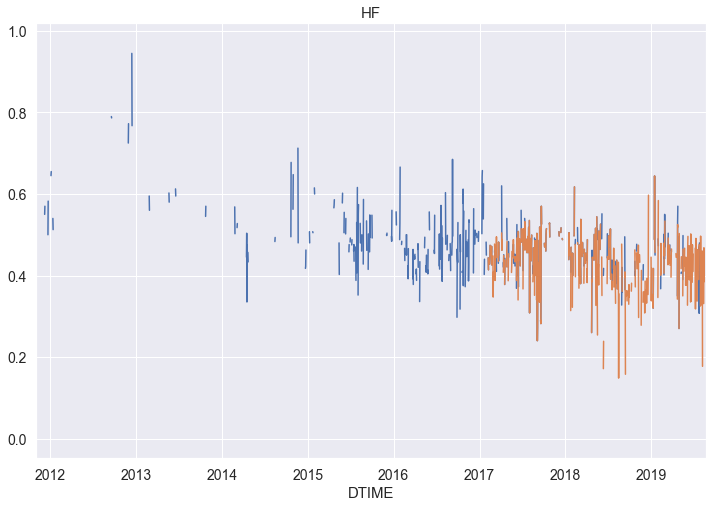

In [11]:
# 设置绘制大小，标题
train.HF.plot(figsize=(12, 8), title='HF', fontsize=140)
test.HF.plot(figsize=(12, 8), title='HF', fontsize=14)
plt.show()
# endregion

In [13]:
# 查看数据
data.head()
# 查看数据集形状
data.shape
# 查看数据集数据类型
data.dtypes

HF        float64
TJMD      float64
ZMD       float64
DZL       float64
NYQD      float64
CO2FYX    float64
RPZXS     float64
KZQD      float64
KQFYX     float64
KQSTL     float64
YJNa      float64
YJSi      float64
YJNi      float64
YJV       float64
YJFe      float64
YJCa      float64
YJS       float64
dtype: object

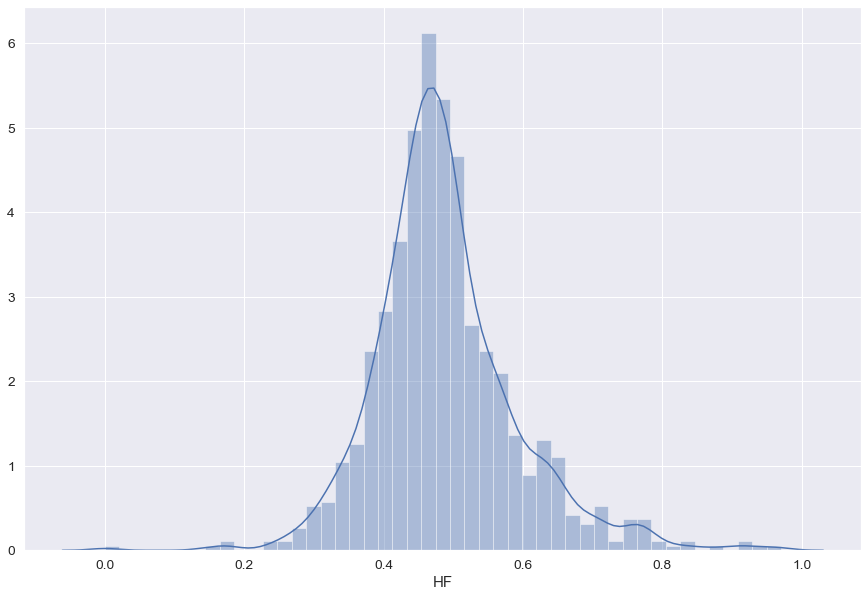

In [14]:
# 2. 分析目标变量 在分析之前，首先要了解目标，查看目标类型、分布，有无异常值。根据不同的类型选择不同的模型。
data['HF'].describe()
# cannot convert float NaN to integer 存在空值
# 删除指定字段[HF]为NaN的行
indexs = list(data[np.isnan(data['HF'])].index)
data = data.drop(indexs)
# 目标变量分布
sns.distplot(data['HF'])
plt.show()

H:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


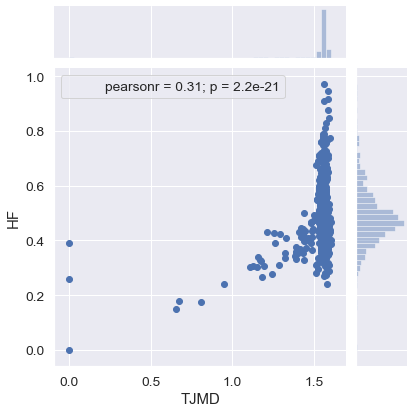

In [15]:
# 3. 挑选最佳特征
# a. 针对连续型变量，可以使用“皮尔逊相关系数”找出与目标变量最相关的特征
# 1） 体积密度
sns.jointplot(x='TJMD', y='HF', data=data, stat_func=sci.pearsonr)

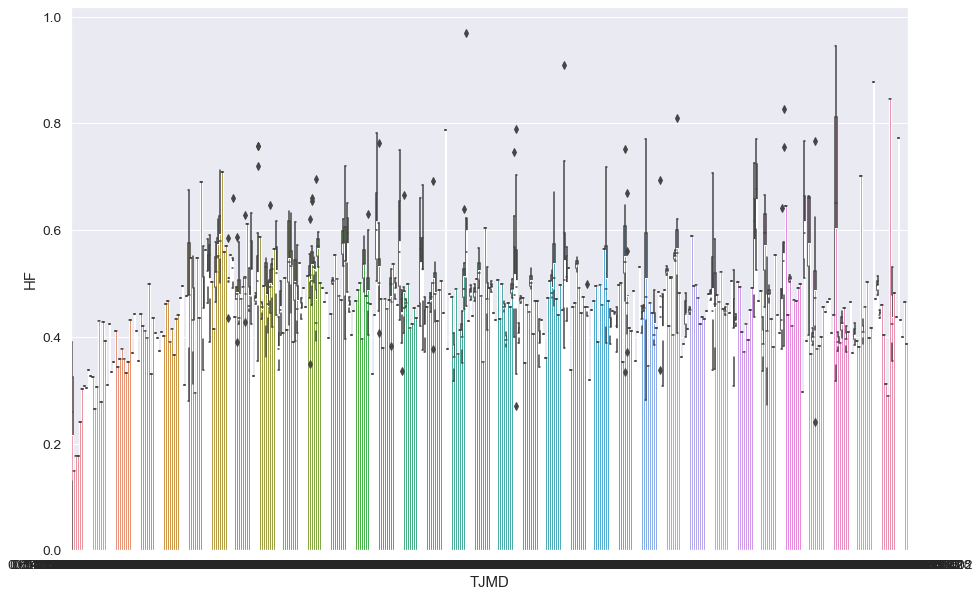

In [17]:
# b. 针对分类变量，无法使用皮尔逊相关系数，可以通过观察每个分类值上目标变量的变化程度来查看相关性，通常来说，在不同值上数据范围变化较大，两变量相关性较大。
# 盒须图
sns.boxplot(x='TJMD', y='HF', data=data)
# 柱状图
grouped = data.groupby('TJMD')
g1 = grouped['HF'].mean().reset_index('TJMD')
sns.barplot(x='TJMD', y='HF', data=g1)

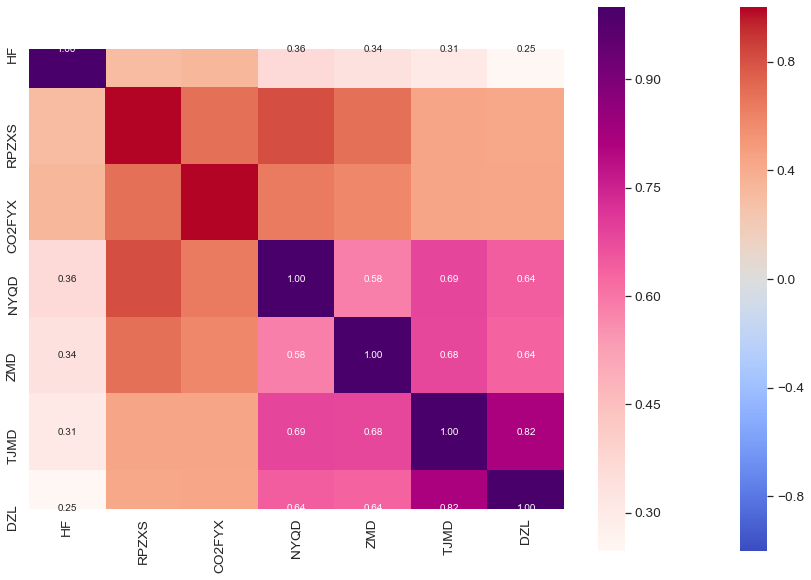

In [18]:
# c. 以上两种分析都是针对单个特征与目标变量逐一分析，这种方法非常耗时繁琐，下面介绍一种系统性分析特征与目标变量相关性的方法，通过对数据集整体特征（数值型数据）进行分析，来找出最佳特征。
# 热力图  sns.heatmap()
# 设置图幅大小
pylab.rcParams['figure.figsize'] = (15, 10)
# 计算相关系数
corrmatrix = data.corr()
# 绘制热力图，热力图横纵坐标分别是data的index/column,vmax/vmin设置热力图颜色标识上下限，center显示颜色标识中心位置，cmap颜色标识颜色设置
sns.heatmap(corrmatrix, square=True, vmax=1, vmin=-1, center=0.0, cmap='coolwarm')
# 特征较多，且相关性不大的特征可以忽略，选取相关性排前k的特征：
# 取相关性前10的特征
k = 10
# data.nlargest(k, 'target')在data中取‘target'列值排前十的行
# cols为排前十的行的index,在本例中即为与’HF‘相关性最大的前十个特征名
cols = corrmatrix.nlargest(k, 'HF')['HF'].index
cm = np.corrcoef(data[cols].values.T)
# data[cols].values.T
# 设置坐标轴字体大小
sns.set(font_scale=1.25)
# sns.heatmap() cbar是否显示颜色条，默认是；cmap显示颜色；annot是否显示每个值，默认不显示；
# square是否正方形方框，默认为False,fmt当显示annotate时annot的格式；annot_kws为annot设置格式
# yticklabels为Y轴刻度标签值，xticklabels为X轴刻度标签值
hm = sns.heatmap(cm, cmap='RdPu', annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)

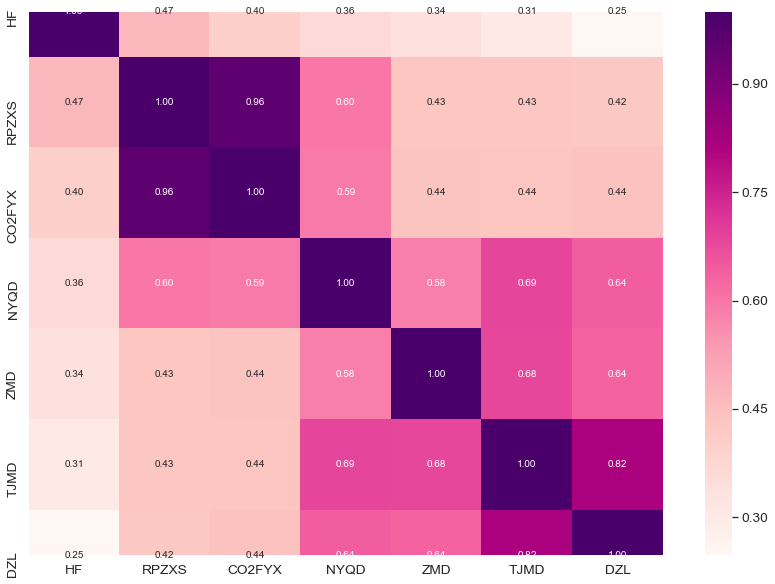

In [19]:
# 上例提供了求相关系数另一种方法，也可以直接用data.corr(),更方便
cm1 = data[cols].corr()
hm2 = sns.heatmap(cm1, square=True, annot=True, cmap='RdPu', fmt='.2f', annot_kws={'size': 10})

plt.show()